# Plotting meteorological data

In [2]:
import xarray as xr
import cartopy
import numpy as np
import cfgrib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import scipy as sp
import scipy.ndimage

# Opening the dataset
GRIBS_FNAME = 'surface_fields_mediterranean_sept2023.grib'
ds = cfgrib.open_datasets(GRIBS_FNAME)[0]

# Color setup
plt.rcParams['hatch.color'] = 'magenta'

# Create a translucent colormap
cmap = plt.cm.YlGn
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
alphas = np.linspace(0, 1, cmap.N)
BG = np.asarray([1., 1., 1.,])
for i in range(cmap.N):
    my_cmap[i,:-1] = my_cmap[i,:-1] * alphas[i] + BG * (1.-alphas[i])
my_cmap = ListedColormap(my_cmap)

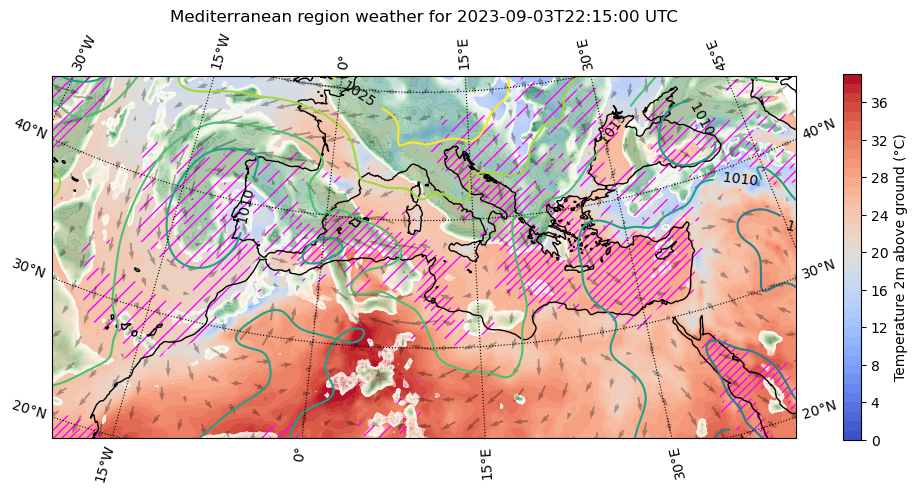

In [6]:
# Here, note the use of the 'transform' argument in the plotting calls
# Note also the ordering of the contours and drawings - opaque contours or
# similar operations will be placed on top of previous objects and thus
# hide them. This is, for example, why we draw the coastlines after the
# temperature contour

def plot_ts(t, 
            show_clabels=True, 
            plot_temperature=True, 
            plot_pressure=True,
            plot_wind=True,
            plot_tcc=True,
            plot_cape=True):
    
    # Retrieve current values through interpolation
    vals = ds.interp(time=t, method="cubic")

    # Coordinate values
    c_lon, c_lat = ds.longitude, ds.latitude
    
    # Create basic fig & axes
    fig = plt.figure(figsize=(12,10), frameon=True)
    lonmin = -20
    lonmax = 40
    avg_lon = 0.5*(lonmin + lonmax)
    proj = ccrs.LambertConformal(central_longitude=avg_lon, central_latitude=40.0)
    ax = plt.axes(projection=proj)
    ax.set_extent([lonmin, lonmax, 20, 48], ccrs.Geodetic())

    # Temperature 
    if plot_temperature:
        temp = vals.t2m.values
        tmin, tmax = 0.0, 40.0
        temp_levels = np.arange(tmin, tmax, 1)
        T = np.clip(temp - 273.15, tmin + 1.01, tmax - 1.01) # Prevent values outside the scale from being blanked out
        temp_contour = ax.contourf(c_lon, c_lat, T, 
                                   temp_levels, 
                                   transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm)
        fig.colorbar(temp_contour, shrink=.475, label="Temperature 2m above ground (°C)")

    ax.coastlines(resolution='50m')
    fig.canvas.draw()

    # Pressure
    if plot_pressure:
        pres_levels = [990, 995, 1000, 1005, 1010, 1015, 1020, 1025]
        # Apply a Gaussian filter to the pressure field to smooth the isobars
        # Careful with this - it will raise local minima and lower local maxima
        P_mbar = vals.msl/100
        sigma = 3
        P = sp.ndimage.gaussian_filter(P_mbar, sigma, mode='nearest')
        pres_contour = ax.contour(c_lon, c_lat, P, pres_levels, transform=ccrs.PlateCarree())
        if show_clabels:
            ax.clabel(
                pres_contour,  # Typically best results when labelling line contours.
                colors=['black'],
                manual=False,  # Automatic placement vs manual placement.
                inline=True,  # Cut the line where the label will be placed.
                fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
            )
    
    # Wind
    if False:
        u = vals.u100
        v = vals.v100
        skip = 8 # This controls the density of the arrows - without it, there will be too many arrows for ants
        ax.quiver(c_lon[::skip], c_lat[::skip], u.values[::skip,::skip], v.values[::skip,::skip], 
                  pivot='mid', alpha=0.75, transform=ccrs.PlateCarree())

    # TCC
    if plot_tcc:
        # Transform monotonically the values to highlight only high TCC regions
        ax.contourf(c_lon, c_lat, -0.3 +  vals.tcc**2, np.linspace(0.0, 1.0, 25), 
                    colors=None, alpha=0.5, transform=ccrs.PlateCarree(), cmap=my_cmap)
    
    # CAPE
    if plot_cape:
        # Similarly, transform the CAPE logarithmically
        # abs(...) here protects us from below-zero interpolated values
        # (original values are >= 0 but cubic interpolation can -and often
        # will - behave like a wobbly boy)
        htch = ax.contourf(c_lon, c_lat, np.log(np.abs(vals.cape) + 1.5)/np.log(12700.0), 
                           [0, 0.25, 0.6, 0.9], 
                           colors=None, hatches=['', '//', '////', '/////'],
                           extend='lower', alpha=0.0, transform=ccrs.PlateCarree())

    # Wind
    if plot_wind:
        u = vals.u100
        v = vals.v100
        skip = 8
        ax.quiver(c_lon[::skip], c_lat[::skip], u.values[::skip,::skip], v.values[::skip,::skip], 
                  pivot='mid', alpha=0.3, transform=ccrs.PlateCarree())
    
    xticks = [-30, -15, 0, 15, 30, 45]
    yticks = [20, 30, 40, 50, 60, 70, 80]

    ax.gridlines(color='black', linestyle=':', xlocs=xticks, ylocs=yticks, 
                 draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.set_title(f"Mediterranean region weather for {str(t)[:19]} UTC")
    
    return fig
#fig = plot_ts(ds.time[70].values, 10)
fig = plot_ts(np.datetime64("2023-09-03T22:15:00.000000000"))

In [ ]:
# Render the animation frames
# This is VERY SLOW - I actually put it in a script and launched multiple 
# processes to generate them in parallel
for i in range(3400):
    plt.close()
    t = ds.time[0].values + i*np.timedelta64(5, 'm')
    fig = plot_ts(t)
    plt.savefig(f"cartofigs/anim_{i:04d}.png", bbox_inches="tight", dpi=600)